In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

from PIL import Image

# Root directory of the project - absolute path
ROOT_DIR = os.path.abspath("/home/nomios/Documents/Projects/deep/cucumber")
DATASET_DIR = os.path.join(ROOT_DIR, "dataset/fruit")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from samples.cucumber import cucumber as cc

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

print(ROOT_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

Using TensorFlow backend.


In [2]:
config = cc.CucumberConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
# Training dataset
dataset_train = cc.CucumberDataset()
dataset_train.load_cucumber(DATASET_DIR, 'train')
dataset_train.prepare()

dataset_dir = os.path.join(DATASET_DIR, 'train')
# file_path = os.path.join(dataset_dir, "annotations.json")
# annot = json.load(open(file_path))
# print(annot["images"][0])
                                          
# Validation dataset
dataset_val = cc.CucumberDataset()
dataset_val.load_cucumber(DATASET_DIR,'val')
dataset_val.prepare()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
class added:  1
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
class added:  1


(4000, 6000, 3)


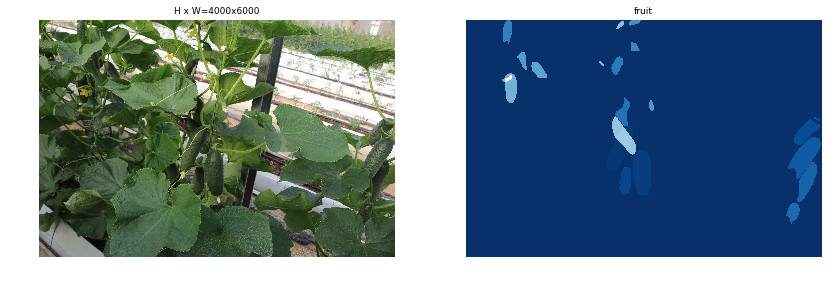

In [4]:
#show n random image&mask train examples
n = 1
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 1)

21


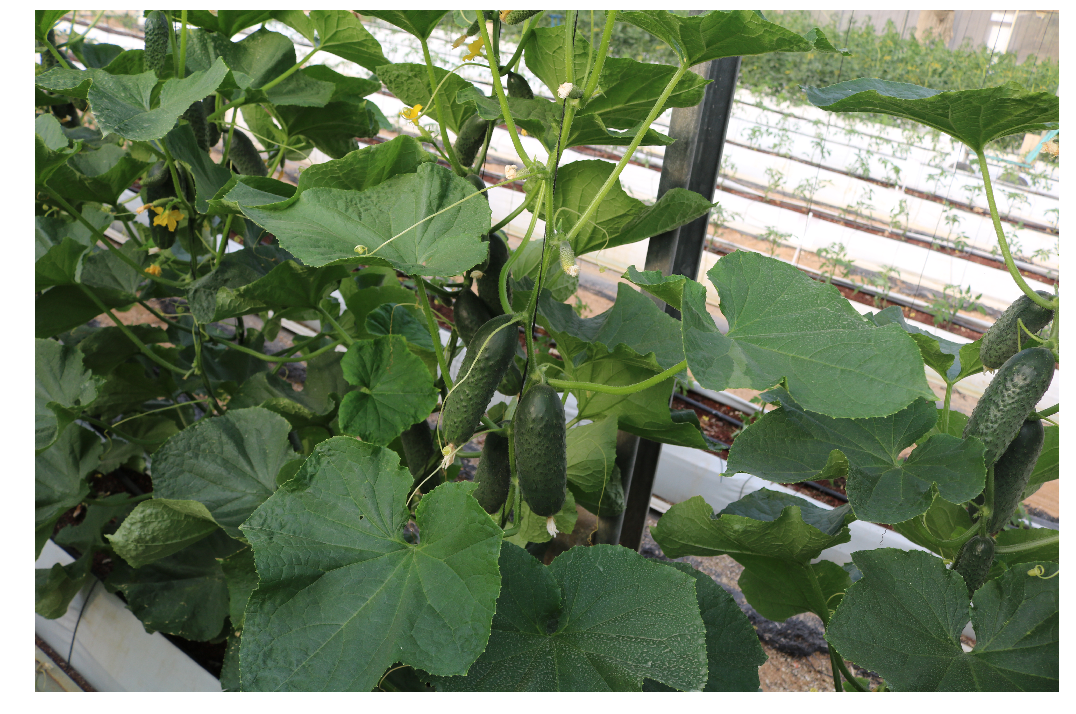

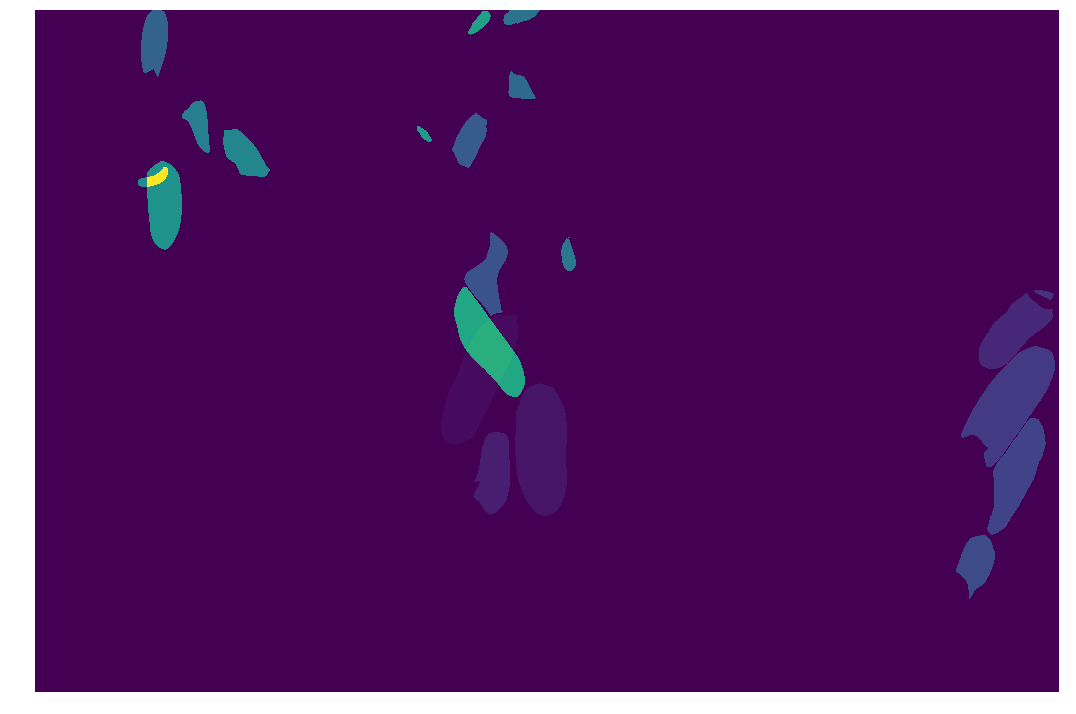

21


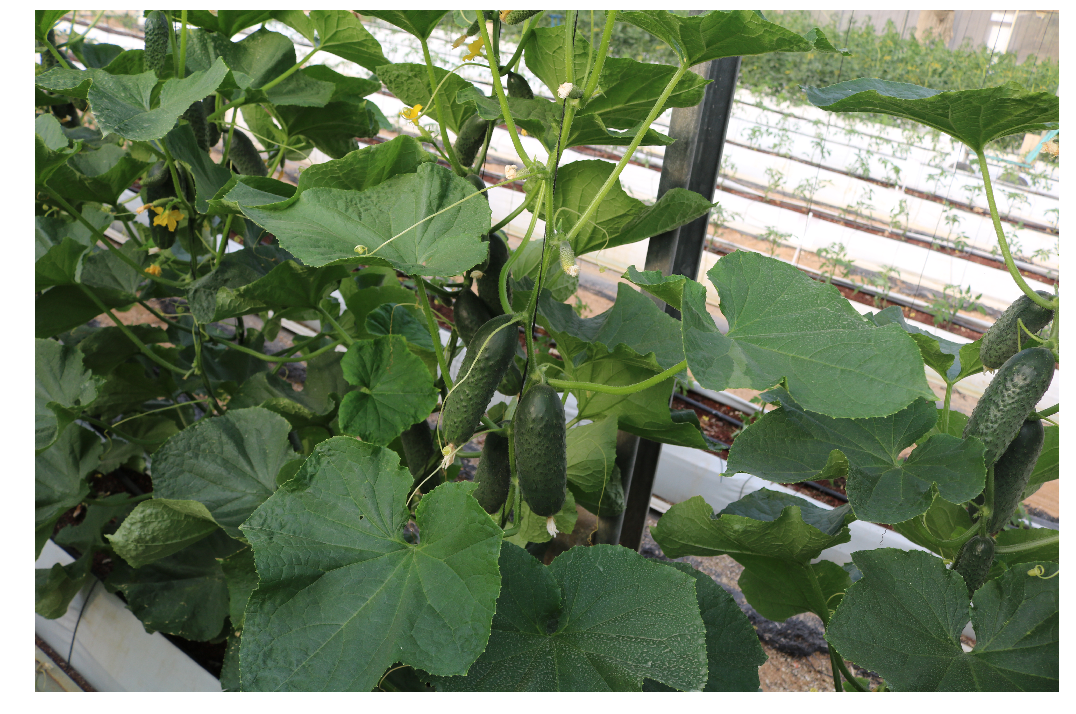

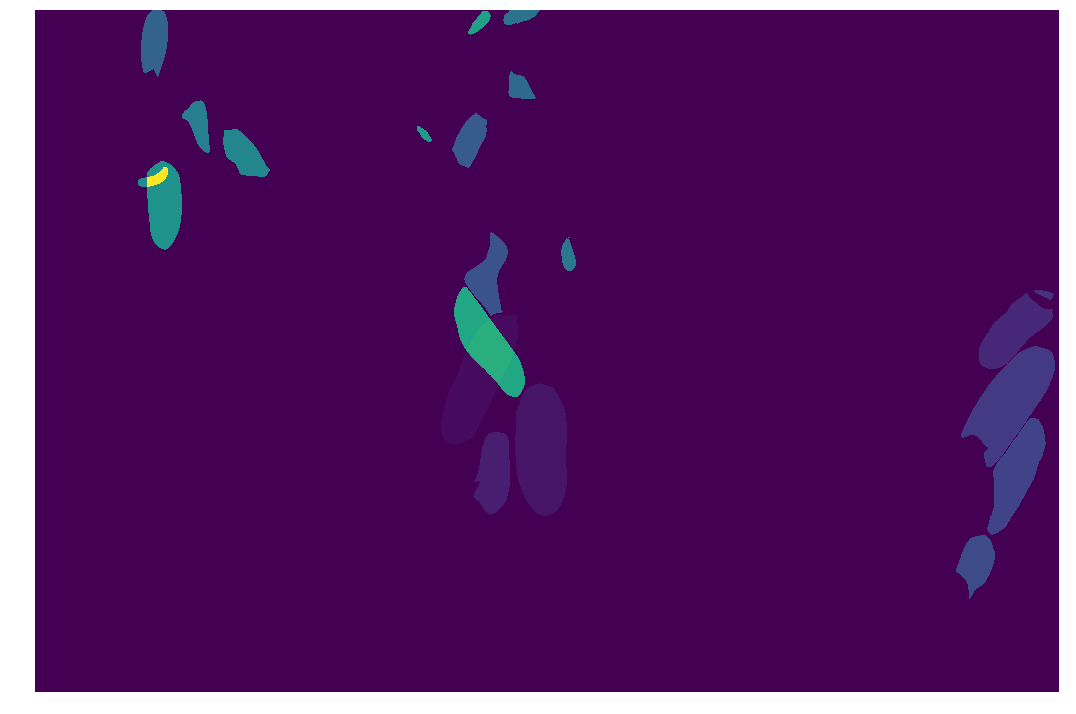

In [4]:
def image_to_mask(image):
    mask = np.zeros_like(image)
    while not np.any(mask):
        color = (0, 0, 0)
        distance = np.sum(image, axis=-1)
        mask = distance > 0
    return mask

def mask_to_image(mask):
    x,y,z = mask.shape
    image = np.zeros((x,y))
    for i in range(0,z):
        image += mask[:,:,i]*(i+1)
    print(z)
    return image

w = 16
h = 16


n = 2
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    
    fig = plt.figure(frameon=False, dpi=64)
    fig.set_size_inches(w,h)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    plt.imshow(image)
    fig.savefig('/home/nomios/Desktop/image' + str(image_id) + '.png')
    
    
    fig = plt.figure(frameon=False, dpi=64)
    fig.set_size_inches(w,h)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    plt.imshow(mask_to_image(mask))
    fig.savefig('/home/nomios/Desktop/mask' + str(image_id) + '.png')

    plt.show()
    


In [4]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [5]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_by_name('/media/master/96DAE970DAE94CD5/Results/Project07 - MaskRCNN/shapes20181015T1115/mask_rcnn_shapes_1517.h5'), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')

In [6]:
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 5, epochs=1, layers="heads")


Starting at epoch 0. LR=0.0002

Checkpoint Path: /home/nomios/Documents/Projects/deep/cucumber/logs/cucumber20181204T0107/mask_rcnn_cucumber_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4      

/home/nomios/.conda/envs/cucumber/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/nomios/.conda/envs/cucumber/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


ValueError: Error when checking input: expected input_image_meta to have shape (93,) but got array with shape (14,)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_17.h5")
model.keras_model.save_weights(model_path)

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model_path = model.find_by_name('/media/master/96DAE970DAE94CD5/Results/Project07 - MaskRCNN/shapes20180827T1511/mask_rcnn_shapes_0150.h5')


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
print(image_id)
#image_id = 1
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

In [ ]:
t = cv2.cvtColor(cv2.imread('/home/master/Work/Tensorflow/Project07 - MaskRCNN/data/results/N08/bananas/bananas_02.jpg'), cv2.COLOR_BGR2RGB)
#original_image.shape
results = model.detect([t], verbose=1)

r = results[0]
visualize.display_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax())
visualize.save_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax(), save_to='/media/global/gip-main/data/Dmitry/temp/result_0150_bananas.png')
t= dataset_train.class_names
print(t)

In [ ]:
#from os import walk
#from os import listdir


class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()


model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
# Recreate the model in inference mode
mypath = '/home/master/Work/logs/shapes20180826T1036/'
mypath_out = '/home/master/Work/logs/temp_out/'

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()


t = cv2.cvtColor(cv2.imread('/home/master/Work/Tensorflow/Project07 - MaskRCNN/data/results/N09/avocado/2018-06-21_AV_leaves_01_1024_02.jpg'), cv2.COLOR_BGR2RGB)
#original_image.shape



#f = []
#for (dirpath, dirnames, filenames) in walk(mypath):
#    print(os.path.join(mypath,filenames))
    #f.extend(filenames)
    #break
    
for filename in sorted(os.listdir(mypath)):
    
    full_name = os.path.join(mypath,filename)
    model_path = model.find_by_name(full_name)
    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    
    results = model.detect([t], verbose=1)

    r = results[0]
    base = os.path.splitext(filename)[0]
    image_name = base + ".png"
    
    visualize.save_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax(), save_to=os.path.join(mypath_out, image_name))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))